In [3]:
#Part2 Project 2 MCMC sampling for parameters

import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd
frbs = pd.read_csv('frb.csv')
frbs

,redshift,DM_obs,DM_MW,name
0,0.03370,348.80,199.0,FRB180916
1,0.11780,338.70,37.2,FRB190608
2,0.19273,558.00,188.0,FRB121102
3,0.29100,363.60,57.3,FRB190102
4,0.32140,361.42,40.5,FRB180924
5,0.37800,321.40,57.8,FRB190611
6,0.47550,589.27,102.0,FRB181112
7,0.52200,593.10,56.4,FRB190711
8,0.66000,760.80,37.0,FRB190523


In [5]:
Ωb=0.02237
χ=0.88
G=6.67408e-11
mₚ=1.6726219e-27
c=299792458
f=0.84
dh= 0.1
h=0.001
H0=0.64

#for generating likelihood function

def sigma(z):
    return np.sqrt((50 / (1 + z))**2 + (40 + 140 * z)**2)
def DMLSS(z,h,H0,Ωm):
    x=np.arange(0,z,h)
    one=np.ones(len(x))
    E=np.sqrt(Ωm*((one + x)**3) + (one*((H0/100)**2-Ωm)))
    return sum(((χ*f*3*100*c*Ωb*H0)/(8*np.pi*mₚ*G))*((one + x)/E)*h*(1.05026504028913e-42))
def DMhost1(z):
    return 100*(( 1 + z )**(-1))


dh= 0.1
H = np.arange(10,110,dh)
h=0.001

#Probablity distribution function for H
def PDF(Ωm,H,z,h,DMo,Ωb):
    sigma1 = sigma(z)
    n = len(z)
    pdf=[]
    for i in range(0,len(H)):
        o=H[i]
        L=[]
        for j in range(0,n):
            L.append((1/(np.sqrt(2*np.pi*sigma1[j]**2)))*(np.exp((-(DMo[j]-DMLSS(z[j],h,H[i],Ωm)-DMhost1(z[j]))**2)/(2*sigma1[j]**2))))
        pdf.append(np.prod(L))
    return pdf

#log liklihood
def llhood(params,z,h,DMo,Ωb):
    H,Ωm,DMhost=params
    sigma1 = sigma(z)
    n = len(z)
    L=[]
    for j in range(0,n):
        L.append((1/(np.sqrt(2*np.pi*sigma1[j]**2)))*(np.exp((-(DMo[j]-DMLSS(z[j],h,H,Ωm)-DMhost*(( 1 + z )**(-1)))**2)/(2*sigma1[j]**2))))
    return np.sum(np.log(L))

In [6]:
z=np.asarray(frbs.redshift)
DMo=np.asarray(frbs.DM_obs)-np.asarray(frbs.DM_MW)

In [7]:
#creating log prior function for variables

def log_prior(params):
    H,Ωm,DMhost=params
    if 0.05 < Ωm < 0.25 and 0 < H < 1.5 and -100 < DMhost < 500:
        return 5.0
    return -np.inf
def log_probability(params,z,h,DMo,Ωb):
    lp=log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + llhood(params,z,h,DMo,Ωb)

In [8]:
#Doing MCMC sampling for frb original data

import emcee

pos = (0.64,0.143,100)+[0.01,0.01,1]*np.random.randn(100,3)
no_of_walkers, dm=pos.shape
sampler=emcee.EnsembleSampler(no_of_walkers, dm, log_probability, args=(z,h,DMo,Ωb) )
sampler.run_mcmc(pos,2000,progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:34<00:00,  7.30it/s]


State([[ 3.77821553e-01  1.66943044e-01 -7.19819959e+00]
 [ 2.96236487e-01  1.00190638e-01 -1.39480730e+01]
 [ 2.61083715e-01  1.13027058e-01  5.69014084e+01]
 [ 2.86691721e-01  1.01279885e-01  7.50312370e+00]
 [ 4.95562975e-01  2.46067456e-01 -4.23142322e+01]
 [ 4.61189519e-01  2.40887428e-01 -1.14814147e+01]
 [ 3.29601896e-01  1.85786688e-01  4.37333554e+01]
 [ 3.32035221e-01  1.20470173e-01 -1.11754765e+01]
 [ 3.22879555e-01  1.41425240e-01  2.09103215e+01]
 [ 2.29700665e-01  6.72121806e-02  3.59961778e+00]
 [ 1.99530689e-01  5.23363969e-02  2.37970304e+00]
 [ 2.53948639e-01  7.81368241e-02  1.22431698e+01]
 [ 2.68828447e-01  9.20858694e-02  1.40031011e+01]
 [ 3.83896403e-01  1.93348548e-01  8.76407970e+00]
 [ 4.13454715e-01  1.99768122e-01 -1.48955910e+01]
 [ 3.08847731e-01  1.60733507e-01  2.48857435e+01]
 [ 4.06713011e-01  2.28621859e-01  1.52810818e+01]
 [ 4.12674283e-01  1.97322570e-01  4.30027193e+00]
 [ 3.56144666e-01  1.67333288e-01  1.74350799e+01]
 [ 4.27375867e-01  2.3783

In [9]:
flat_samples = sampler.get_chain(discard=50, thin=40, flat=True)
print(flat_samples.shape)

(4800, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

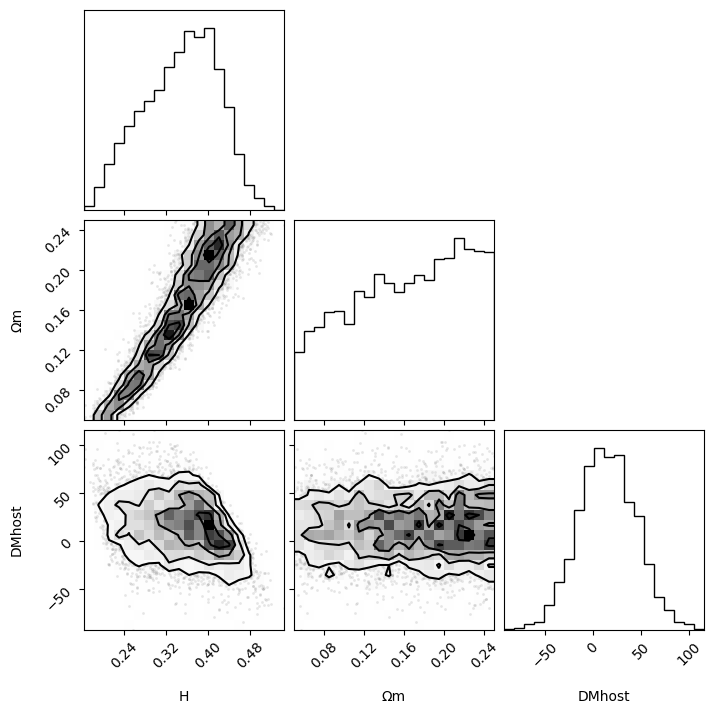

In [10]:
import corner

fig = corner.corner(flat_samples, labels=["H","Ωm","DMhost"] )
plt.show

In [11]:
#mock data for DM and z
z_array=np.linspace(0.01,1,50)
pdfn=(z_array**2)* np.exp(-4.*z_array)
pdfn=pdfn/(sum(pdfn))
z=np.random.choice(z_array,size=50, p=pdfn) 



DMo=[]
for i in range(0,len(z_array)):
    Omega_m=0.143
    z1=z[i]
    DMo.append(DMLSS(z1,h,H0,Omega_m)+np.random.normal(loc=0,scale=sigma(z1)))

In [12]:
#Doing MCMC sampling for mock data

import emcee

pos = (0.64,0.143,500)+[0.01,0.001,5]*np.random.randn(25,3)
no_of_walkers, dm=pos.shape
sampler=emcee.EnsembleSampler(no_of_walkers, dm, log_probability, args=(z,h,DMo,Ωb) )
sampler.run_mcmc(pos,500,progress=True)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\run\AppData\Local\Programs\Python\Python311\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.88it/s]


State([[  0.57820855   0.12060154 -15.91367269]
 [  0.40630497   0.05940544 -12.76165504]
 [  0.56018056   0.11316195 -17.81605356]
 [  0.61601438   0.13688175 -11.25671376]
 [  0.75218787   0.20711366  -2.71976394]
 [  0.60155065   0.13045331 -13.63362871]
 [  0.6775998    0.1653865  -10.75394722]
 [  0.63358262   0.14184424 -30.8600884 ]
 [  0.5344352    0.10367886  -9.95152875]
 [  0.57850652   0.1203841  -14.46350608]
 [  0.68068762   0.16893753  -7.20755123]
 [  0.51545068   0.0972542   -1.71635662]
 [  0.77995869   0.21997806  -8.80731638]
 [  0.62184114   0.13984377  -9.98321014]
 [  0.72268483   0.18662821 -24.6797112 ]
 [  0.69178627   0.17379973 -17.43184435]
 [  0.75089858   0.208078    -0.34484342]
 [  0.55003351   0.10968647 -10.98738373]
 [  0.53195767   0.10292318 -13.154739  ]
 [  0.57309932   0.11746653 -17.3112545 ]
 [  0.69699743   0.17758095  -5.86928533]
 [  0.80766897   0.23693803 -13.13776964]
 [  0.38479985   0.05333539 -13.62415586]
 [  0.40888379   0.0605512  

In [13]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(750, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

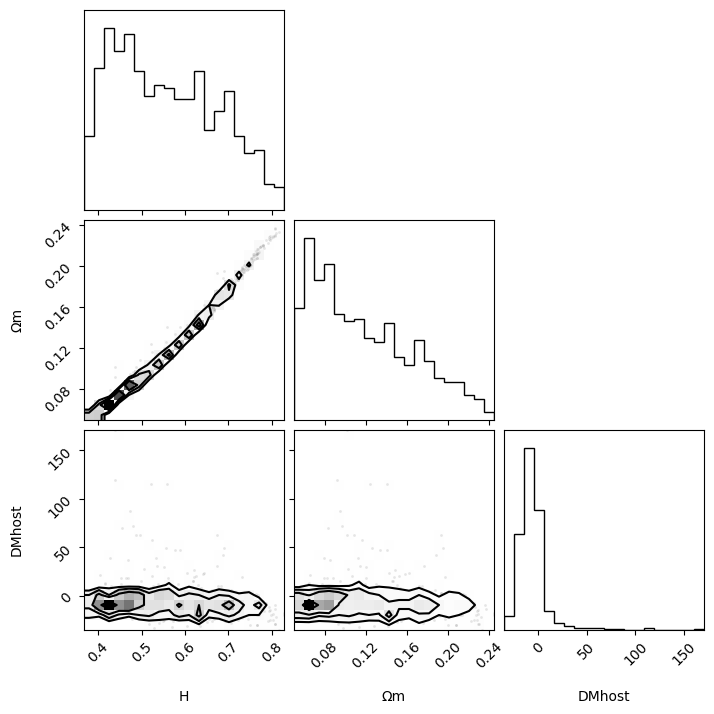

In [14]:
import corner

fig = corner.corner(flat_samples,labels=["H","Ωm","DMhost"] )
plt.show